## Local Explanations for a given scene

### Imports

In [1]:
import os
import sys
#Add project root to sys.path
sys.path.append(os.path.abspath(".."))

In [15]:
from policy_graph.policy_graph import AVPolicyGraph
from policy_graph.pg_utils import load_scene, setup_env_and_disc, DATA_ROOT
from policy_graph.plot_utils import plot_int_progess,animate_int_progress
import pickle

### Scene Details

1. Choose a scene

    Some interesting scenes:
    * 1084: {id: 'affb0caa5d2948f98cee5c42c7aefc1c',  city: "singapore-hollandvillage"}
    * 0234: {id:'0053e9c440a94c1b84bd9c4223efc4b0', city:'boston-seaport'}



In [ ]:
#from trainval split
#scene_token = 'affb0caa5d2948f98cee5c42c7aefc1c'
#scene_city = 'singapore-hollandvillage'
#scene_id = '1084'

#from mini split
scene_token='2fc3753772e241f2ab2cd16a784cc680' 
scene_city='boston-seaport'
scene_id = '0757'

2. Extract scene data from dataset

In [4]:
scenes_states_file = 'full_v1.0-mini.csv'
scenes_camera_file = 'cam_data_v1.0-mini_18.csv'

scene_df, scene_cam_df = load_scene(scene_token, scenes_states_file, scenes_camera_file)

3. Convert scene into discretized state-action trajectory

In [5]:
# initialize empty PG
env, disc = setup_env_and_disc(scene_city, discretizer_id = '0b')
pg = AVPolicyGraph(env, disc)

# discretize trajectory as [s,a,s',...]
trajectory = pg._run_episode(scene_df, scene_cam_df, verbose=False) 

# convert in state-action trajectory [(s,a), (s',a'),...]
state_action_trajectory = [(trajectory[i], int(trajectory[i + 1])) for i in range(0, len(trajectory) - 1, 2)]
state_action_trajectory.append((trajectory[-1], None)) 


### Intention Evolution troughout the Scene 

Load existing IPG

In [6]:
ipg_file = 'IPG_nuscenes_mini_Call_D0b_Wall_Tall.pkl'
intention_folder = f'{DATA_ROOT}/intentions'

with open(f"{intention_folder}/{ipg_file}", 'rb') as f:
    ipg= pickle.load(f)

Plot Intention Evolution in Scene (static or animated)

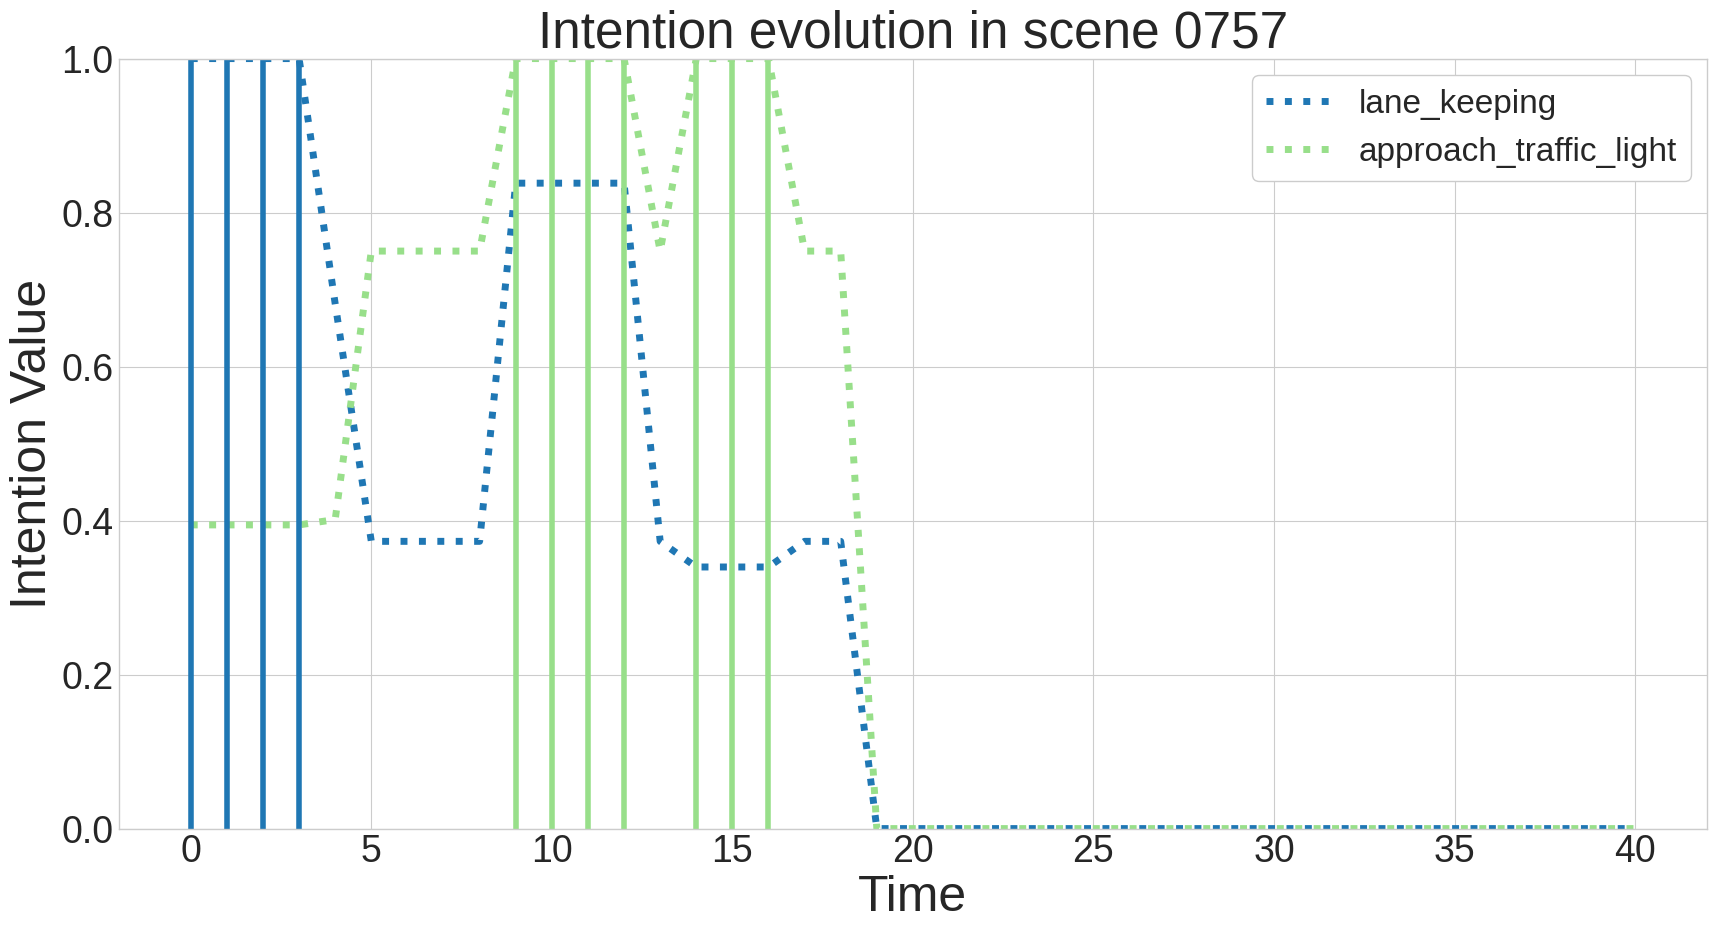

In [14]:
plot_int_progess(ii=ipg, s_a_trajectory=state_action_trajectory,min_int_threshold=0.2, scene_id=scene_id, output_folder=f'{intention_folder}/img')

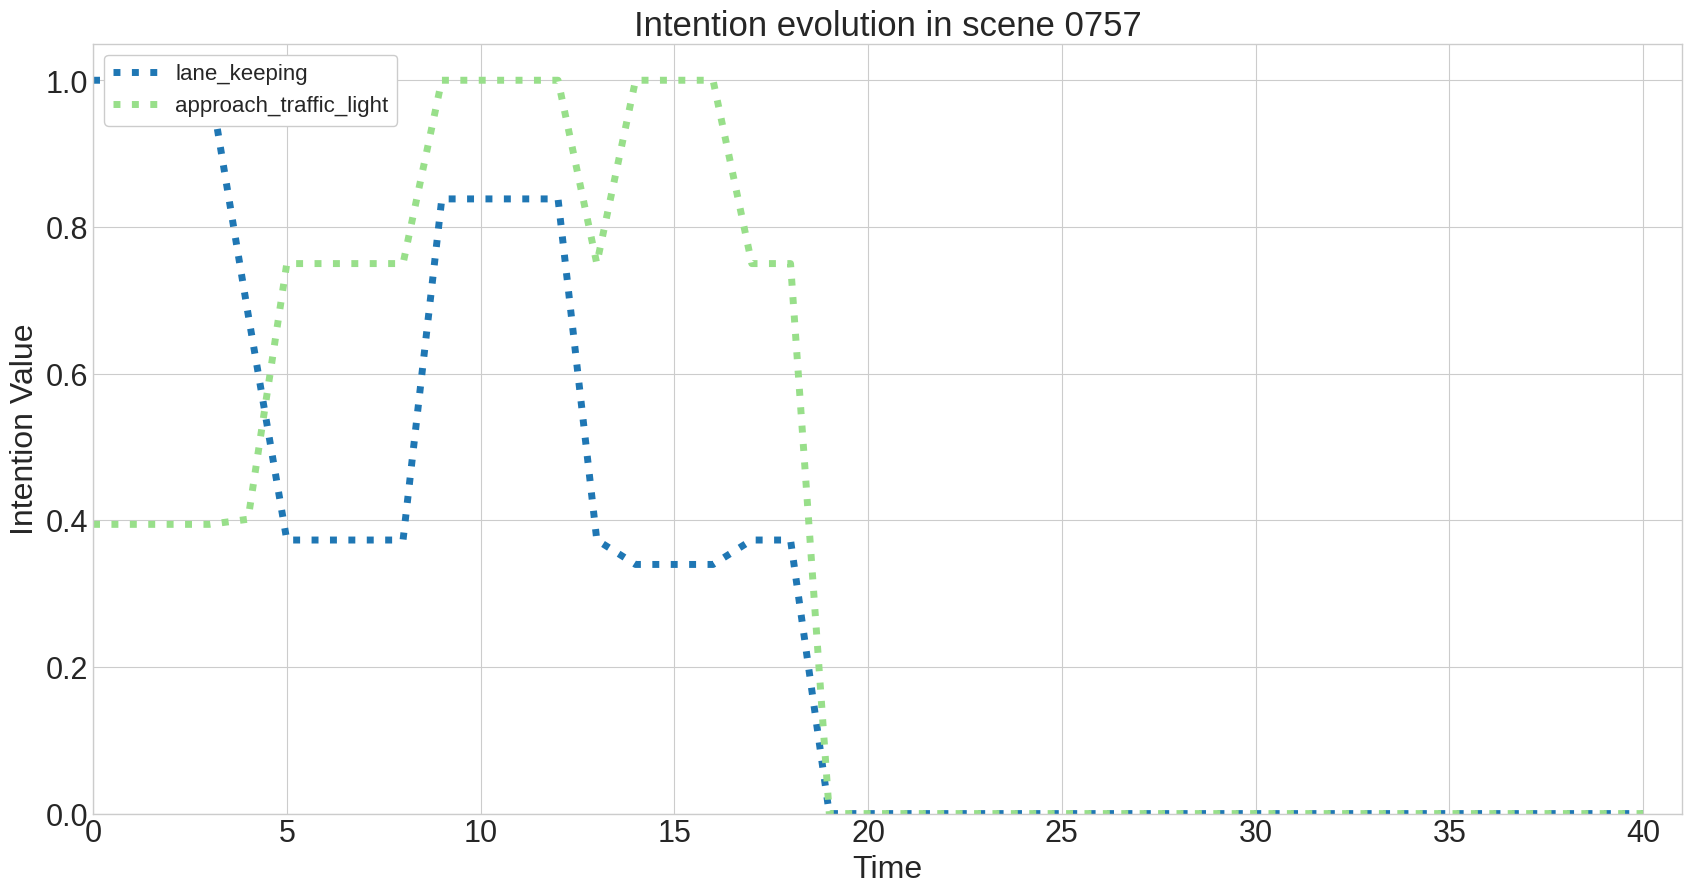

In [16]:
animate_int_progress(ii = ipg, s_a_trajectory=state_action_trajectory,min_int_threshold=0.2, scene_id=scene_id, output_folder=f'{intention_folder}/img')

### QA Example

Decide which state to analyse. Let's analyze the intentions at time 20:

In [39]:
state_id = 10
state = state_action_trajectory[state_id][0]
state

(LanePosition(ALIGNED),
 NextIntersection(NONE),
 Velocity(LOW),
 Rotation(FORWARD),
 StopAreaNearby(NO),
 IsZebraNearby(YES),
 IsTrafficLightNearby(YES),
 FrontObjects(NO))

Define a commitment threshold

In [37]:
commitment_threshold = 0.2

Q1: What do you intent to do in [state _s_]?

In [40]:
ipg.what_question(state, commitment_threshold) 

What do you intend to do in state (LanePosition(ALIGNED), NextIntersection(NONE), Velocity(LOW), Rotation(FORWARD), StopAreaNearby(NO), IsZebraNearby(YES), IsTrafficLightNearby(YES), FrontObjects(NO))?
Attributed intention of the following desires: [('lane_keeping', np.float64(0.8381970349423118)), ('approach_traffic_light', np.float64(1.0))]


Q2: How do you plan to do [desire _d_]?

In [41]:
desire = ipg.desires[3]
ipg.how_question(desire, state)

How do you plan to fulfill lane_change_left from state (LanePosition(ALIGNED), NextIntersection(NONE), Velocity(LOW), Rotation(FORWARD), StopAreaNearby(NO), IsZebraNearby(YES), IsTrafficLightNearby(YES), FrontObjects(NO))?
From such state there is not path to fulfill the desire.


Q3: Why do you take _a_ in state _s_?

In [42]:
action_id = 5
ipg.why_question(state, action_id, c_threshold=commitment_threshold, probability_threshold = 0 )


I want to do Action.BRAKE for the purpose of furthering Desire[lane_keeping]=<{<enum 'LanePosition'>: [<LanePosition.ALIGNED: 2>], <enum 'Rotation'>: [<Rotation.FORWARD: 2>], <enum 'NextIntersection'>: [<NextIntersection.NONE: 4>, <NextIntersection.STRAIGHT: 3>], <enum 'Velocity'>: [<Velocity.HIGH: 4>, <Velocity.LOW: 2>, <Velocity.MEDIUM: 3>]}, [4, 5, 6]> as it has a 0.750 probability of an expected intention increase of 0.000
I want to do Action.BRAKE for the purpose of furthering Desire[approach_traffic_light]=<{<enum 'IsTrafficLightNearby'>: [<IsTrafficLightNearby.YES: 1>], <enum 'Velocity'>: [<Velocity.LOW: 2>, <Velocity.MEDIUM: 3>]}, [1, 5, 9, 10]> as it has a 0.750 probability of an expected intention increase of 0.000


Q3 for every action:

In [43]:
for action_id in range(1,10):
    ipg.why_question(state, action_id, c_threshold=commitment_threshold, probability_threshold = 0 )


Action Action.IDLE does not seem intentional.
Action Action.TURN_LEFT does not seem intentional.
Action Action.TURN_RIGHT does not seem intentional.
Action Action.GAS does not seem intentional.
I want to do Action.BRAKE for the purpose of furthering Desire[lane_keeping]=<{<enum 'LanePosition'>: [<LanePosition.ALIGNED: 2>], <enum 'Rotation'>: [<Rotation.FORWARD: 2>], <enum 'NextIntersection'>: [<NextIntersection.NONE: 4>, <NextIntersection.STRAIGHT: 3>], <enum 'Velocity'>: [<Velocity.HIGH: 4>, <Velocity.LOW: 2>, <Velocity.MEDIUM: 3>]}, [4, 5, 6]> as it has a 0.750 probability of an expected intention increase of 0.000
I want to do Action.BRAKE for the purpose of furthering Desire[approach_traffic_light]=<{<enum 'IsTrafficLightNearby'>: [<IsTrafficLightNearby.YES: 1>], <enum 'Velocity'>: [<Velocity.LOW: 2>, <Velocity.MEDIUM: 3>]}, [1, 5, 9, 10]> as it has a 0.750 probability of an expected intention increase of 0.000
Action Action.STRAIGHT does not seem intentional.
Action Action.GAS_TUR